Multi Layer Perceptron @ Bengio

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Reading the dataset

In [2]:
words = open(file="names.txt", mode="r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

Building character to index and vice-versa mappings


In [4]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

Creating the dataset with context window

In [5]:
window = 3
X, Y = [], []

for w in words:

  # print(w)
  context = [0] * window
  for ch in w + ".":
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print("".join(itos[i] for i in context), "==>", itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Lookup table

In [7]:
C = torch.randn(size=(27, 2))

In [8]:
embed = C[X]
embed.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn(size=(6, 100))
b1 = torch.randn(size=(100,))

In [10]:
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([228146, 100])

In [11]:
W2 = torch.randn(size=(100, 27))
b2 = torch.randn(size=(27,))

In [12]:
logits = h @ W2 + b2

In [13]:
logits.shape

torch.Size([228146, 27])

In [14]:
counts = logits.exp()

In [15]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [16]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [112]:
gen = torch.Generator().manual_seed(2147483647)

C = torch.randn(size=(27, 10), generator=gen)
W1 = torch.randn(size=(30, 200), generator=gen)
b1 = torch.randn(size=(200,), generator=gen)
W2 = torch.randn(size=(200, 27), generator=gen)
b2 = torch.randn(size=(27,), generator=gen)

params = [C, W1, b1, W2, b2]

In [113]:
sum(p.nelement() for p in params)

11897

In [114]:
for p in params:

  p.requires_grad = True

In [20]:
loss_list = []

In [115]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [116]:
lri = []
lr_loss = []
stepi = []

In [127]:
for i in range(50000):

  # mini-batch
  ix = torch.randint(0, X_train.shape[0], (32,))

  # forward pass
  embed = C[X_train[ix]]
  h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[ix])
  # loss_list.append(loss.item())
  # print(loss.item())

  # backward pass
  # lr = lrs[i]
  for p in params:
    p.grad = None

  loss.backward()

  # update
  for p in params:
    p.data += -0.01 * p.grad

  # stats
  # lri.append(lre[i])
  stepi.append(i)
  lr_loss.append(loss.item())

loss.item()

1.9459733963012695

In [128]:
embed = C[X_dev]
h = torch.tanh(embed.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss.item()

2.172678232192993

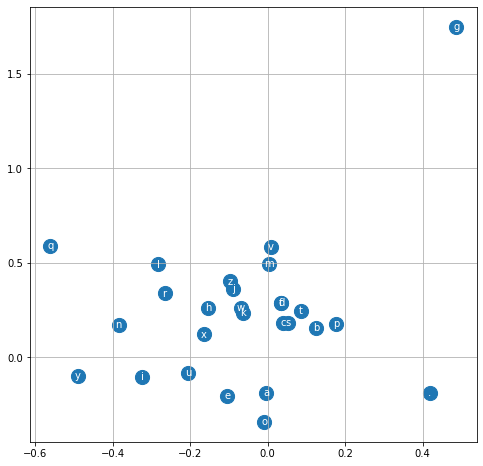

In [109]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

Data splitting into train, dev, test

In [44]:
# building the dataset

def build_dataset(words):

  window = 3
  X, Y = [], []

  for w in words:

    # print(w)
    context = [0] * window
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print("".join(itos[i] for i in context), "==>", itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [45]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [51]:
n1, n2, len(words), n2 - n1, len(words) - n1

(25626, 28829, 32033, 3203, 6407)